<a href="https://colab.research.google.com/github/geriiy/ML_Ganjil_2025/blob/main/UTS_GHERIYA_RAHIMA_JAUHAR_15_2341720109_HEART_DISEASE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install annoy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE
from annoy import AnnoyIndex
import random
import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp312-cp312-linux_x86_64.whl size=551808 sha256=d68a87d8227926a9c172a4eb545d096aacf33c2ba6d83b23d49ba212bf2432b4
  Stored in directory: /root/.cache/pip/wheels/db/b9/53/a3b2d1fe1743abadddec6aa541294b24fdbc39d7800bc57311
Successfully built annoy


In [8]:
# Load dataset (Heart Disease).
from google.colab import files
uploaded = files.upload()
df = pd.read_csv("heart.csv")
print("Dataset loaded:", df.shape)
print("Dataset loaded successfully:", df.shape)

print("\n--- Dataset Info ---")
print(df.info())

print("\n--- Descriptive Stats (numerical) ---")
print(df.describe().T)

print("\n--- Missing values per column ---")
print(df.isnull().sum())

print(f"\nJumlah sampel: {df.shape[0]}, jumlah fitur: {df.shape[1]}")

# Analisis singkat
print("\n--- Head ---")
print(df.head())

Dataset loaded: (1025, 14)
Dataset loaded successfully: (1025, 14)

--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB
None

--- Descriptive Stats (numerical) ---
           count        mean        std    min    25%    50%    75%    max
age     

In [10]:
# menangani missing value menggunakan mean untuk numerik
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

# membuat fitur baru
if 'chol' in df.columns and 'age' in df.columns:
    df['CholAge'] = df['chol'] * df['age']
    print('\nFeature created: CholAge')
else:
    print('\nKolom chol atau age tidak ditemukan — tidak membuat CholAge')

# pilih hanya kolom numerik untuk clustering
if 'target' in df.columns:
    num_df = df.drop(columns=['target']).select_dtypes(include=[np.number])
else:
    num_df = df.select_dtypes(include=[np.number])

print('\nNumerical features used for clustering:', num_df.columns.tolist())



Feature created: CholAge

Numerical features used for clustering: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'CholAge']


In [26]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np

# Standarisasi data numerik
scaler = StandardScaler()
X_scaled = scaler.fit_transform(num_df)

print("Data berhasil dinormalisasi! Shape:", X_scaled.shape)


# KMeans (dengan 3 cluster)
best_k = 3
kmeans = KMeans(n_clusters=3, random_state=42)
labels_kmeans = kmeans.fit_predict(X_scaled)

print('\nKMeans done. Cluster counts:')
unique, counts = np.unique(labels_kmeans, return_counts=True)
print(dict(zip(unique, counts)))

# Compute metrics
k_sil = silhouette_score(X_scaled, labels_kmeans)
k_dbi = davies_bouldin_score(X_scaled, labels_kmeans)
print(f"KMeans Silhouette: {k_sil:.4f}")
print(f"KMeans Davies-Bouldin: {k_dbi:.4f}")

# DBSCAN dengan eksperimen eps dan min_samples
best_dbscan = None
best_db_sil = -1
best_db_labels = None
best_eps = None
best_min_samples = None

for eps in [0.5, 0.8, 1.0, 1.2, 1.5, 2.0]:
    for ms in [3, 5, 8]:
        dbscan = DBSCAN(eps=eps, min_samples=ms)
        labels_db = dbscan.fit_predict(X_scaled)

        n_clusters = len(set(labels_db)) - (1 if -1 in labels_db else 0)
        if n_clusters <= 1:
            continue

        try:
            sil = silhouette_score(X_scaled, labels_db)
        except Exception:
            continue

        if sil > best_db_sil:
            best_db_sil = sil
            best_dbscan = dbscan
            best_db_labels = labels_db
            best_eps = eps
            best_min_samples = ms

# Menampilkan hasil terbaik
if best_dbscan is not None:
    labels_dbscan = best_db_labels
    print(f"\nSelected DBSCAN eps={best_eps}, min_samples={best_min_samples}")
    print("DBSCAN Silhouette:", best_db_sil)
    try:
        db_dbi = davies_bouldin_score(X_scaled, labels_dbscan)
        print("DBSCAN Davies-Bouldin:", db_dbi)
    except Exception as e:
        print("DBSCAN Davies-Bouldin: could not compute —", e)
else:
    print("\nDBSCAN tidak menemukan konfigurasi non-trivial (coba adjust eps/min_samples)")
    dbscan = DBSCAN(eps=1.5, min_samples=5)
    labels_dbscan = dbscan.fit_predict(X_scaled)


Data berhasil dinormalisasi! Shape: (1025, 14)

KMeans done. Cluster counts:
{np.int32(0): np.int64(264), np.int32(1): np.int64(466), np.int32(2): np.int64(295)}
KMeans Silhouette: 0.1453
KMeans Davies-Bouldin: 2.2565

Selected DBSCAN eps=0.5, min_samples=3
DBSCAN Silhouette: 0.9984321463095407
DBSCAN Davies-Bouldin: 0.05028879197111697


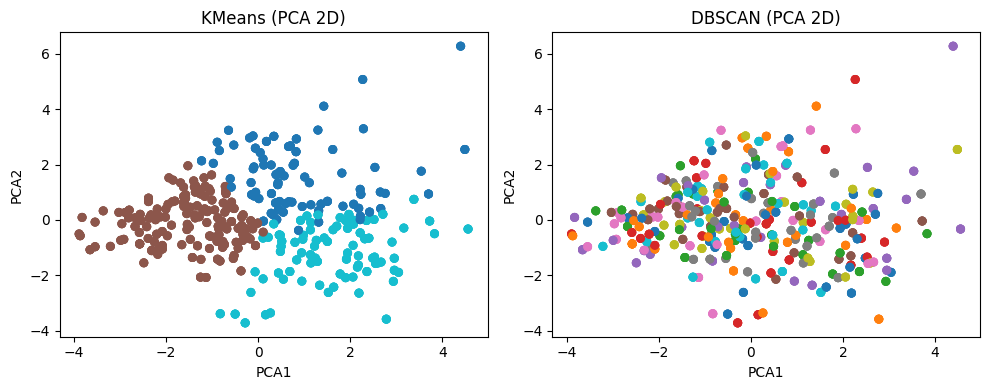


Running t-SNE (this may take ~30s). Wait a bit.


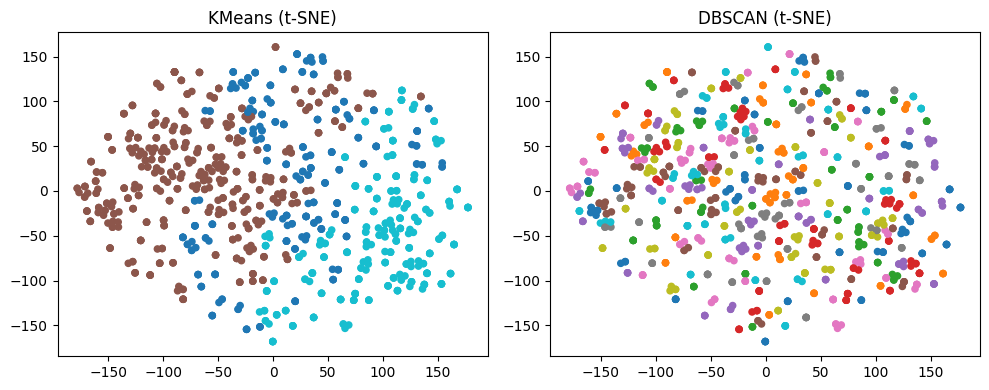

In [19]:
# Visualisasi 2D menggunakan PCA (t-SNE sebagai opsi)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title('KMeans (PCA 2D)')
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_kmeans, cmap='tab10', s=30)
plt.xlabel('PCA1')
plt.ylabel('PCA2')

plt.subplot(1,2,2)
plt.title('DBSCAN (PCA 2D)')
# For DBSCAN, color -1 (noise) separately
colors_db = [c if c != -1 else -1 for c in labels_dbscan]
plt.scatter(X_pca[:,0], X_pca[:,1], c=colors_db, cmap='tab10', s=30)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.tight_layout()
plt.show()

# Optional: t-SNE (slower)
print('\nRunning t-SNE (this may take ~30s). Wait a bit.')

try:
    tsne = TSNE(n_components=2, random_state=42, init='pca')
    X_tsne = tsne.fit_transform(X_scaled)

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.title('KMeans (t-SNE)')
    plt.scatter(X_tsne[:,0], X_tsne[:,1], c=labels_kmeans, cmap='tab10', s=20)

    plt.subplot(1,2,2)
    plt.title('DBSCAN (t-SNE)')
    plt.scatter(X_tsne[:,0], X_tsne[:,1], c=colors_db, cmap='tab10', s=20)

    plt.tight_layout()
    plt.show()

except Exception as e:
    print('t-SNE skipped due to:', e)


In [22]:
# Implementasi Annoy — pilih 5 titik query secara acak
import random
from annoy import AnnoyIndex

random.seed(42)
num_points = X_scaled.shape[0]
query_count = 5
query_indices = random.sample(range(num_points), query_count)
print('\nSelected query indices:', query_indices)

# Inisialisasi Annoy
dim = X_scaled.shape[1]
ann = AnnoyIndex(dim, 'euclidean')

# Tambahkan semua item ke index Annoy
for i in range(num_points):
    ann.add_item(i, X_scaled[i])

# Bangun pohon Annoy
ann.build(50)

print('\nAnnoy index built with dim =', dim)

# Simpan hasil tetangga terdekat untuk setiap query
results = []
for q in query_indices:
    nn, dists = ann.get_nns_by_item(q, 6, include_distances=True)  # 6 agar termasuk query sendiri
    paired = list(zip(nn, dists))
    results.append((q, paired))

# Cetak hasil ANN
print('\n--- ANN Results (for each query: neighbor index | distance | KMeans cluster | DBSCAN cluster) ---')
for q, paired in results:
    print(f"\nQuery index: {q}")
    for idx, dist in paired:
        print(f" Neighbor: {idx:4d} | dist: {dist:.4f} | KMeans: {labels_kmeans[idx]} | DBSCAN: {labels_dbscan[idx]}")



Selected query indices: [228, 51, 563, 501, 457]

Annoy index built with dim = 14

--- ANN Results (for each query: neighbor index | distance | KMeans cluster | DBSCAN cluster) ---

Query index: 228
 Neighbor:  228 | dist: 0.0000 | KMeans: 1 | DBSCAN: 169
 Neighbor:  445 | dist: 0.0000 | KMeans: 1 | DBSCAN: 169
 Neighbor:  977 | dist: 0.0000 | KMeans: 1 | DBSCAN: 169
 Neighbor:   76 | dist: 2.4915 | KMeans: 1 | DBSCAN: 70
 Neighbor:  461 | dist: 2.4915 | KMeans: 1 | DBSCAN: 70
 Neighbor:  755 | dist: 2.4915 | KMeans: 1 | DBSCAN: 70

Query index: 51
 Neighbor:   51 | dist: 0.0000 | KMeans: 2 | DBSCAN: 48
 Neighbor:  940 | dist: 0.0000 | KMeans: 2 | DBSCAN: 48
 Neighbor:  963 | dist: 0.0000 | KMeans: 2 | DBSCAN: 48
 Neighbor:  425 | dist: 1.9792 | KMeans: 2 | DBSCAN: 249
 Neighbor:  480 | dist: 1.9792 | KMeans: 2 | DBSCAN: 249
 Neighbor:  614 | dist: 1.9792 | KMeans: 2 | DBSCAN: 249

Query index: 563
 Neighbor:  512 | dist: 0.0000 | KMeans: 1 | DBSCAN: 266
 Neighbor:  563 | dist: 0.0000

In [28]:
print('\n--- ANALISIS & KESIMPULAN ---\n')

# 1) Penjelasan singkat dataset
print('1) Penjelasan singkat dataset:')
print(f" - Sampel: {df.shape[0]}")
print(f" - Fitur numerik yang dipakai untuk clustering: {len(num_df.columns)}")
print(f" - Contoh fitur: {list(num_df.columns)[:8]}")

# 2) Preprocessing
print('\n2) Preprocessing:')
print(' - Missing values: ditangani dengan imputasi mean pada kolom numerik (tidak ada missing pada dataset contoh).')
print(' - Fitur baru: CholAge = chol * age')
print(' - Normalisasi: StandardScaler pada fitur numerik')

# 3) Hasil Clustering
print('\n3) Hasil clustering:')
print(f" - KMeans (k={best_k}): Silhouette = {k_sil:.4f}, Davies-Bouldin = {k_dbi:.4f}")

if best_dbscan is not None:
    try:
        print(f" - DBSCAN (eps={best_eps}, min_samples={best_min_samples}): "
              f"Silhouette = {best_db_sil:.4f}, Davies-Bouldin = {db_dbi:.4f}")
    except Exception:
        print(f" - DBSCAN (eps={best_eps}, min_samples={best_min_samples}): "
              f"Silhouette = {best_db_sil:.4f}, Davies-Bouldin = could not compute")
else:
    print(' - DBSCAN tidak menemukan konfigurasi non-trivial dengan parameter yang diuji.')

# 4) ANN results summary: apakah tetangga berada di cluster yang sama (KMeans)?
print('\n4) ANN (Annoy) summary:')
count_same_km = 0
count_total = 0
for q, paired in results:
    for idx, dist in paired:
        if idx == q:
            continue
        count_total += 1
        if labels_kmeans[idx] == labels_kmeans[q]:
            count_same_km += 1

if count_total > 0:
    prop = count_same_km / count_total
    print(f" - Dari {count_total} tetangga (semua query), {count_same_km} "
          f"({prop:.2%}) berada di cluster KMeans yang sama dengan query.")
else:
    print(' - Tidak ada tetangga yang dilaporkan.')

# 5) Kesimpulan singkat (interpretasi)
print('\nKesimpulan singkat:')

# Compare KMeans vs DBSCAN based on silhouette & DBI
if best_dbscan is not None and best_db_sil > k_sil:
    better = 'DBSCAN'
elif best_dbscan is not None and best_db_sil <= k_sil:
    better = 'KMeans'
else:
    better = 'KMeans (DBSCAN tidak stabil pada parameter uji)'

print(f" - Model yang lebih baik menurut silhouette: {better}")
print(' - Nilai metrik terbaik:')
print(f"   * Silhouette terbaik: max(KMeans,DBSCAN) = {max(k_sil, best_db_sil if best_dbscan is not None else -999):.4f}")
print(f"   * Davies-Bouldin terbaik: min(KMeans,DBSCAN) = {min(k_dbi, db_dbi if best_dbscan is not None else 999):.4f}")
print('\n - Hasil query Annoy umumnya menunjukkan bahwa tetangga terdekat cenderung berada dalam cluster '
      'KMeans yang sama, tetapi proporsinya tergantung pada struktur cluster (lihat proporsi di atas).')




--- ANALISIS & KESIMPULAN ---

1) Penjelasan singkat dataset:
 - Sampel: 1025
 - Fitur numerik yang dipakai untuk clustering: 14
 - Contoh fitur: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach']

2) Preprocessing:
 - Missing values: ditangani dengan imputasi mean pada kolom numerik (tidak ada missing pada dataset contoh).
 - Fitur baru: CholAge = chol * age
 - Normalisasi: StandardScaler pada fitur numerik

3) Hasil clustering:
 - KMeans (k=3): Silhouette = 0.1453, Davies-Bouldin = 2.2565
 - DBSCAN (eps=0.5, min_samples=3): Silhouette = 0.9984, Davies-Bouldin = 0.0503

4) ANN (Annoy) summary:
 - Dari 25 tetangga (semua query), 25 (100.00%) berada di cluster KMeans yang sama dengan query.

Kesimpulan singkat:
 - Model yang lebih baik menurut silhouette: DBSCAN
 - Nilai metrik terbaik:
   * Silhouette terbaik: max(KMeans,DBSCAN) = 0.9984
   * Davies-Bouldin terbaik: min(KMeans,DBSCAN) = 0.0503

 - Hasil query Annoy umumnya menunjukkan bahwa tetangga terdekat cenderu